This notebook willbe used to explore the tidal ellipses conversions and manipulation at the VENUS nodes.

##Loading and Preparing Data
First we import all the necessary packages

In [51]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import research_VENUS

%matplotlib inline


Now we import the bathymetry of the model

In [52]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

Next, we need the quarter-hourly updated u and v velocities from the model at the VENUS nodes. The function below will combine all the files with the variable and append them to make one long array

In [53]:
def combine_gridded(files, var):
    """function to combine a model variable from a list of many files. 
    Returns an array of the variabel and associated model times.
    Suitable for use with the VENUS_east_gridded.nc and VENUS_central_gridded.nc files.
    Only for variables over depth.
    """
    #empty arrays
    time = np.array([])
    var_list=[]

    for f in files:
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:,:,:,:]
        #append variable to array
        var_list.append(var_tmp)
        t = nc_tools.timestamp(G, np.arange(var_tmp.shape[0]))
        for ind in range(len(t)):
            t[ind] = t[ind].datetime
        time = np.append(time, t)
        
    var_ary=np.concatenate(var_list,axis=0)
    return var_ary,time

The following function is the same as above but adapted to work for the variables like time_counter and depth that only have one dimention but are still very useful for tidal ellipses

In [70]:
def combine_t(files, var):
    """function to combine a model variable from a list of many files. 
    Returns an array of the variabel and associated model times.
    Suitable for use with the VENUS_east.nc and VENUS_central.nc files.
    Only for variables with one dimension, ex: time counter and depth
    """
    #empty arrays
    time = np.array([])
    var_list=[]

    for f in files:
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:]
        #append variable to array
        var_list.append(var_tmp)
        t = nc_tools.timestamp(G, np.arange(var_tmp.shape[0]))
        for ind in range(len(t)):
            t[ind] = t[ind].datetime
        time = np.append(time, t)
        
    var_ary=np.concatenate(var_list,axis=0)
    return var_ary,time

Now we will find ALL the files that end with VENUS_east_gridded.nc and VENUS_central_gridded.nc and put them end to end. These dataset started to be recorded on May 9th 2015.

In [55]:
path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
files = glob.glob(os.path.join(path,'*','*_1h_*_grid_T*'))
    
files = []
files_East = glob.glob(os.path.join(path,'*','VENUS_east_gridded.nc'))
for f in files_East:
    directory=os.path.dirname(f)
    files.append(glob.glob(os.path.join(directory,'*_1h_*_grid_T*'))[0])
files.sort(key=os.path.basename)

files_East = [];
files_Central=[];
for f in files:
    directory=os.path.dirname(f)
    files_East.append(os.path.join(directory,'VENUS_east_gridded.nc'))
    files_Central.append(os.path.join(directory,'VENUS_central_gridded.nc'))

In [56]:
u_u_c, time = combine_gridded(files_Central, 'vozocrtx')
v_v_c, time = combine_gridded(files_Central, 'vomecrty')
time_c, time = combine_t(files_Central, 'time_counter')
dep_t_c, time = combine_t(files_Central, 'depthv')
time_c = time_c/3600

u_u_e, time = combine_gridded(files_East,'vozocrtx')
v_v_e, time = combine_gridded(files_East,'vomecrty')
time_e, time = combine_t(files_East, 'time_counter')
dep_t_e, time = combine_t(files_East, 'depthv')
time_e = time_e/3600


We must unstagger and rotate the u and v velocities to have them be evaluated at the same center grid point then rotated to have u as the East/West velocities and v as the North/South velocities.

In [57]:
u_c, v_c=research_VENUS.unstag_rot_gridded(u_u_c, v_v_c, 'Central')
u_e, v_e=research_VENUS.unstag_rot_gridded(u_u_e, v_v_e, 'East')
u_c.shape


(1344, 40)

##Set-up Tide Information
We will allocate space for the tidal components M2 and K1 for each u and c and set the frequencies of these two tidal component, these are already known.

In [58]:
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
K1freq = 15.041069*np.pi/180.

thesize=40

vM2amp = np.zeros(thesize); vM2pha = np.zeros(thesize)
vK1amp = np.zeros(thesize); vK1pha = np.zeros(thesize)
uM2amp = np.zeros(thesize); uM2pha = np.zeros(thesize)
uK1amp = np.zeros(thesize); uK1pha = np.zeros(thesize)

Now this is the function we will try to fit to our model:

In [59]:
display(Math(r'u = mean + A_{M2}cos(w_{M2}t-\theta_{M2}) + A_{K1}cos(w_{K1}t-\theta_{K1})'))
display(Math(r'v = mean + A_{M2}cos(w_{M2}t-\theta_{M2}) + A_{K1}cos(w_{K1}t-\theta_{K1})'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This assumes the current is only affected by M2 and K1 which is not true but a good approximation because they are the two major components at the chosen locations

In [60]:
# function for fit, this assumes two tides only
def double(x, M2amp, M2pha, K1amp, K1pha, mean):
    return (mean + M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.))

In [61]:
# function to do the fitting and actually find the tidal components
def fittit (uaus, vaus, time):
    for dep in np.arange(0,39):
        if vaus[:,dep].any() != 0.:
            fitted, cov = curve_fit(double,time[:],vaus[:,dep]) 
        if fitted[0] < 0:
            fitted[0] = -fitted[0]
            fitted[1] = fitted[1]+180.
        if fitted[1] > 180:
            fitted[1] = fitted[1] - 360.
        elif fitted[1] < -180-360:
            fitted[1] = fitted[1] + 720.
        elif fitted [1] < -180:
            fitted[1] = fitted[1] + 360.
        if fitted[2] < 0:
            fitted[2] = -fitted[2]
            fitted[3] = fitted[3]+180.
        vM2amp[dep] = fitted[0]
        vM2pha[dep] = fitted[1]
        vK1amp[dep] = fitted[2]
        vK1pha[dep] = fitted[3]

    for dep in np.arange(0,39):
        if uaus[:,dep].any() !=0.:
            fitted, cov = curve_fit(double,time[:],uaus[:,dep]) 
        if fitted[0] < 0:
            fitted[0] = -fitted[0]
            fitted[1] = fitted[1]+180.
        if fitted[1] > 180+360:
            fitted[1] = fitted[1] -720
        elif fitted[1] > 180:
            fitted[1] = fitted[1] - 360.
        elif fitted[1] < -180-360:
            fitted[1] = fitted[1] + 720.
        elif fitted [1] < -180:
            fitted[1] = fitted[1] + 360.
        if fitted[2] < 0:
            fitted[2] = -fitted[2]
            fitted[3] = fitted[3]+180.
        uM2amp[dep] = fitted[0]
        uM2pha[dep] = fitted[1]
        uK1amp[dep] = fitted[2]
        uK1pha[dep] = fitted[3]
    return vM2amp, vM2pha, vK1amp, vK1pha, uM2amp, uM2pha, uK1amp, uK1pha

In [62]:
# this function calculates ellipse parameters based on the amplitude and phase.  From Foreman (1977)
def ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha):
    CX = uM2amp*np.cos(np.pi*uM2pha/180.)
    SX = uM2amp*np.sin(np.pi*uM2pha/180.)
    CY = vM2amp*np.cos(np.pi*vM2pha/180.)
    SY = vM2amp*np.sin(np.pi*vM2pha/180.)
    ap = np.sqrt((CX+SY)**2+(CY-SX)**2)/2.  # amplitude of positively rotating component
    am = np.sqrt((CX-SY)**2+(CY+SX)**2)/2.  # amplitude of negatively rotating component
    ep = np.arctan2(CY-SX,CX+SY)+np.pi       # phase of positive
    em = np.arctan2(CY+SX,CX-SY)+np.pi      # phase of negative
    major = ap+am                           # major axis
    minor = ap-am                           # signed minor axis
    theta = (ep+em)/2.*180./np.pi           # axis tilt
    theta %= 180                             # by convention theta is between 0 and 180.
    return CX, SX, CY, SY, ap, am, ep, em, major, minor, theta

Now we will run the fit for the Central and East nodes

In [63]:
vM2ampc, vM2phac, vK1ampc, vK1phac, uM2ampc, uM2phac, uK1ampc, uK1phac = fittit (u_c, v_c, 
                                                                         time_c)

CX_c, SX_c, CY_c, SY_c, ap_c, am_c, ep_c, em_c, major_c, minor_c, theta_c = ellipse_params (uM2ampc, uM2phac, vM2ampc, vM2phac)
CX_ck, SX_ck, CY_ck, SY_ck, ap_ck, am_ck, ep_ck, em_ck, major_ck, minor_ck, theta_ck = ellipse_params (uK1ampc, uK1phac, vK1ampc, vK1phac)

In [64]:
vM2ampe, vM2phae, vK1ampe, vK1phae, uM2ampe, uM2phae, uK1ampe, uK1phae = fittit (u_e, v_e, 
                                                                         time_e)
CX_e, SX_e, CY_e, SY_e, ap_e, am_e, ep_e, em_e, major_e, minor_e, theta_e= ellipse_params (uM2ampe, uM2phae, vM2ampe, vM2phae)

CX_ek, SX_ek, CY_ek, SY_ek, ap_ek, am_ek, ep_ek, em_ek, major_ek, minor_ek, theta_ek= ellipse_params (uK1ampe, uK1phae, vK1ampe, vK1phae)



##Plotting Tidal Ellipses 
Now we will plot the surface tidal ellipse.


red is clockwise


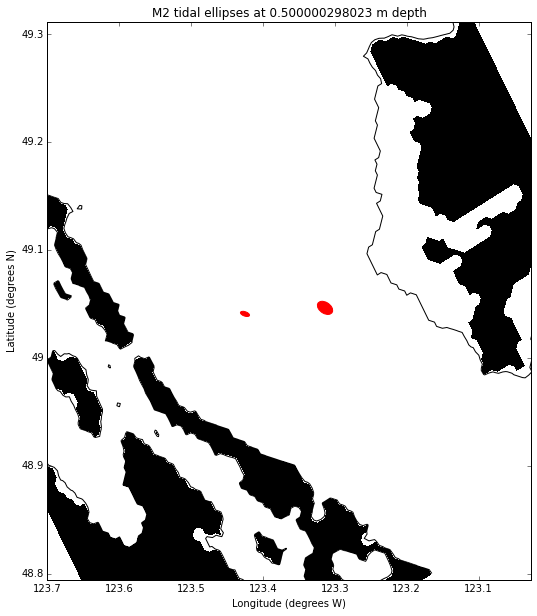

In [65]:
# rotate grid, then label axes in lats/longs

phi = 29. # the twist in the grid
k = np.zeros((898,398)); m = np.zeros((898,398))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 60

#Inverted i and j to match code
imin=416 #East node y
imax=424 #Central mode y
jmin=266 #East node x
jmax=283 #Central node x

for i in np.arange(imin-ex,imax+ex):
    for j in np.arange(jmin-ex,jmax+ex):
        k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 
scale = 8.
interval = 4
depth=0
#Making the ellipse for the Central node
if ap_c[depth] > am_c[depth]:
    thec1 = 'b'
else:
    thec1 = 'r'
ells1 = Ellipse(xy=(m[imax,jmin],k[imax,jmin]), width=scale*major_c[depth], 
    height=scale*minor_c[depth], angle=theta_c[depth]+29.,
    color=thec1)

#Making the ellipse for the East node
if ap_e[depth] > am_e[depth]:
    thec2 = 'b'
else:
    thec2 = 'r'
ells2 = Ellipse(xy=(m[imin,jmax],k[imin,jmax]), width=scale*major_e[depth], 
    height=scale*minor_e[depth], angle=theta_e[depth]+29.,
    color=thec2)
    
    
ax.add_artist(ells1)
ax.add_artist(ells2)
ells1.set_facecolor(thec1)
ells2.set_facecolor(thec2)
# y-axis in k, but labelled in latitude
ax.set_ylim(445,560)
slope = (lats[imax,jmin]-lats[imin,jmin])/(k[imax,jmin]-k[imin,jmin])
mylist = (k[imin,jmin]+(np.arange(48.8, 49.35, 0.1)-
                           lats[imin,jmin])/slope).tolist()
labels = ['48.8', '48.9', '49', '49.1', '49.2', '49.3']
ax.set_yticks(mylist); ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
ax.set_xlim(-14,94)
slope = (lons[imin,jmax]-lons[imin,jmin])/(m[imin,jmax]-m[imin,jmin])
mylist = (m[imin,jmin]+(np.arange(-123.7,-123.05,0.1)-
                        lons[imin,jmin])/slope).tolist()
labels = ['123.7','123.6','123.5','123.4','123.3','123.2','123.1','123']
ax.set_xticks(mylist); ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')


# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],contour_interval,colors='black')
ax.contour(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],[5],colors='black')
ax.set_title('M2 tidal ellipses at {dep} m depth'.format(dep=dep_t_c[depth]))

print "red is clockwise"



#Tracing out the Ellipses


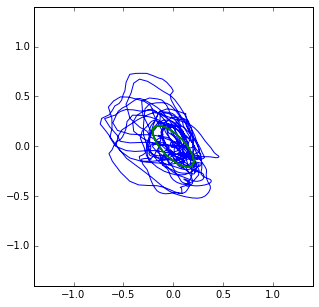

In [66]:
#Central
i=266
j=424
depth=0
plt.figure(figsize=(5,5))
plt.plot(u_c[:,depth],v_c[:,depth])
plt.xlim(-1.4,1.4)
plt.ylim(-1.4,1.4)
x=np.arange(0,95)
plt.plot(CX_c[depth]*np.cos(M2freq*x)+SX_c[depth]*np.sin(M2freq*x),
         CY_c[depth]*np.cos(M2freq*x)+SY_c[depth]*np.sin(M2freq*x));



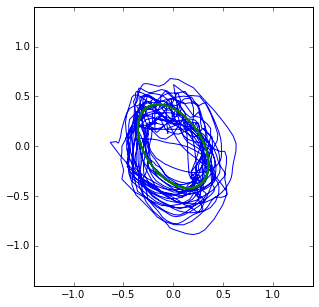

In [67]:
#East
i=283
j=416
depth=0
plt.figure(figsize=(5,5))
plt.plot(u_e[:,depth],v_e[:,depth])
plt.xlim(-1.4,1.4)
plt.ylim(-1.4,1.4)
x=np.arange(0,95)
plt.plot(CX_e[depth]*np.cos(M2freq*x)+SX_e[depth]*np.sin(M2freq*x),
         CY_e[depth]*np.cos(M2freq*x)+SY_e[depth]*np.sin(M2freq*x));

##Depth Profile of Tidal Ellipses

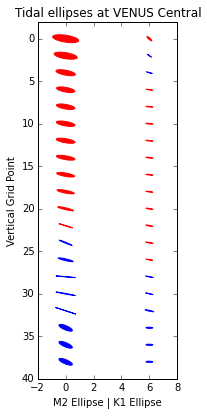

In [68]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for dep in np.arange(0,40,interval):
    if ap_c[dep] > am_c[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*major_c[dep], 
                        height=scale*minor_c[dep], angle=-theta_c[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for dep in np.arange(0,40,interval):
    if ap_ck[dep] > am_ck[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*major_ck[dep], 
                        height=scale*minor_ck[dep], angle=-theta_ck[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS Central')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('M2 Ellipse | K1 Ellipse')

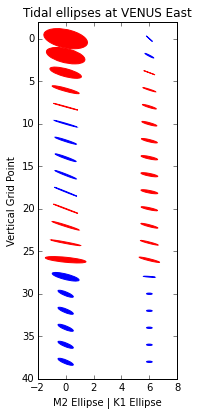

In [69]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for dep in np.arange(0,40,interval):
    if ap_e[dep] > am_e[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*major_e[dep], 
                        height=scale*minor_e[dep], angle=-theta_e[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for dep in np.arange(0,40,interval):
    if ap_ek[dep] > am_ek[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*major_ek[dep], 
                        height=scale*minor_ek[dep], angle=-theta_ek[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS East')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('M2 Ellipse | K1 Ellipse')